# Anticipez les besoins en consommation de bâtiments

## Partie 3:    Modélisation target 'TotalGHGEmissions'

#### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder,QuantileTransformer, FunctionTransformer, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, SelectFromModel, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error as mse, classification_report
from sklearn import linear_model
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
import datetime
from datetime import datetime
from sklearn.svm import SVR
import math
import xgboost
from xgboost import XGBRegressor
import shap
import warnings
warnings.filterwarnings('ignore')


#### Chargement jeu de données

In [2]:
#chargement du dataset néttoyé du notebook 1
df=pd.read_csv('data_clean.csv')
df.head()

BuildingAge        BuildingType        PrimaryPropertyType Neighborhood  \
0         89.0      NonResidential  Hotel/Senior Care/Housing     DOWNTOWN   
1         90.0      NonResidential  Hotel/Senior Care/Housing     DOWNTOWN   
2         17.0  Nonresidential COS                      Other     DOWNTOWN   
3         90.0      NonResidential  Hotel/Senior Care/Housing     DOWNTOWN   
4         90.0      NonResidential                      Other     DOWNTOWN   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0            12.0           88434.0                 0.0   
1                1.0            10.0           61320.0                 0.0   
2                1.0             2.0           97288.0             37198.0   
3                1.0            11.0           83008.0                 0.0   
4                1.0             8.0          102761.0                 0.0   

   PropertyGFABuilding(s)     LargestPropertyUseType  ...  \
0                 88434.0  Hotel/Senior Care/Housing  ...   
1                 61320.0  Hotel/Senior Care/Housing  ...   
2                 60090.0             Police Station  ...   
3                 83008.0  Hotel/Senior Care/Housing  ...   
4                102761.0                    Leisure  ...   

   SiteEnergyUseWN(kBtu) SiteEUIWN(kBtu/sf)  TotalGHGEmissions  \
0              7456910.0          84.300003             249.98   
1              6946800.5         113.300003             286.43   
2             12581712.0         141.600006             301.81   
3              6062767.5          74.500000             176.14   
4              7067881.5          68.800003             221.51   

  GHGEmissionsIntensity  ENERGYSTARScore  SteamUse(kBtu)  Electricity(kBtu)  \
0                  2.83             60.0      2003882.00          3946027.0   
1                  4.67             56.0      2214446.25          2768924.0   
2                  3.10              NaN            0.00          7371434.0   
3                  2.12             27.0            0.00          2811215.0   
4                  2.16              NaN      2276286.50          3636655.0   

   NaturalGas(kBtu)    Surface  energytype_count  
0         1276453.0  1061208.0                 3  
1         1811213.0   613200.0                 3  
2         4715182.0   120180.0                 2  
3         2947580.0   913088.0                 2  
4          385189.0   822088.0                 3  

[5 rows x 25 columns]

Création d'un dataframe 'energystarscore_df' comprenant la variable 'ENERGYSTARScore'

In [3]:
#separation de la colonne ENERGYSTARScore
energystarscore_df = df['ENERGYSTARScore']

In [4]:
#créons une copie de notre dataset
table=df.copy()

Selection des variables 

In [5]:
features= ['energytype_count',
    'Surface',
    'BuildingAge',
    'PrimaryPropertyType',
    'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
    'TotalGHGEmissions']

In [6]:
#Sélection des variables 
df=df[features]

In [7]:
data=df.copy()

Pour la target 'TotalGHGEmissions', nous choisissons de faire une transformation en log des variables numériques et un onehotencoder de nos variables calégorielles 

#### Preprocessing

In [8]:
#fonction de transformation en log
def transformation_en_log(df):
    cont_feats = [col for col in df.columns if df[col].dtype != object]
    for var in cont_feats:
        df[var]=np.log1p(df[var])
    return df 

In [9]:
#fonction encodage OneHotEncoder
def encodage(df):
    cont_feats = [col for col in df.columns if df[col].dtype != object]
    cat_feats = [col for col in df.columns if col not in cont_feats]
    df_ohe=df[cat_feats]
    transformer =OneHotEncoder(sparse=False,handle_unknown='ignore')
    transformed = transformer.fit_transform(df_ohe)
    transformed_df = pd.DataFrame(transformed,columns=transformer.get_feature_names_out())
    df_num=df[cont_feats]
    df_encoded=pd.concat(objs=[df_num.reset_index(drop=True), transformed_df.reset_index(drop=True)],axis=1)
    return df_encoded

In [10]:
#separation du dataset
def separation(df):
    y= df['TotalGHGEmissions']
    X = df.drop('TotalGHGEmissions', axis=1)
    return X, y

In [11]:
#fonction de preprocessing
def preprocessing(df):
    df=transformation_en_log(df)
    df=encodage(df)
    #separation du dataset
    y= df['TotalGHGEmissions']
    X = df.drop('TotalGHGEmissions', axis=1)
    splitter=StratifiedShuffleSplit(n_splits=10,random_state=42) 
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    return (X_train, y_train, X_test, y_test)
    

In [12]:
#Séparation du Dataset
X_train, y_train, X_test, y_test= preprocessing(data)

### Modélisation 

In [13]:
def model_selection(X_train, y_train, estimator):
    """
    Test various estimators.
    """
    model = estimator
    
    model.fit(X_train, y_train)  

    expected  = y_test
    predicted = model.predict(X_test)

    return (("le score d'entrainement est de ", model.score(X_train, y_train)),
            
            ("le score r2",estimator,"est de ", r2_score(expected, predicted)))

Testons les modèles linéaires suivants: 
  -  Ridge,
  -  Lasso, 
  -  ElasticNet,
  -  Random Forest Regressor,
  -  XGBRegressor

#### Ridge

In [14]:
model_selection(X_train, y_train, Ridge())

(("le score d'entrainement est de ", 0.6592765375040415),
 ('le score r2', Ridge(), 'est de ', 0.6907375770471031))

#### ElasticNet

In [15]:
model_selection(X_train, y_train,  ElasticNet())

(("le score d'entrainement est de ", 0.04697523528006431),
 ('le score r2', ElasticNet(), 'est de ', 0.042813038799430436))

#### Lasso

In [16]:
model_selection(X_train, y_train, Lasso())

(("le score d'entrainement est de ", 0.0),
 ('le score r2', Lasso(), 'est de ', -0.00995402814198365))

#### Random Forest Regressor

In [17]:
model_selection(X_train, y_train, RandomForestRegressor())

(("le score d'entrainement est de ", 0.9475928941325155),
 ('le score r2', RandomForestRegressor(), 'est de ', 0.6848526366364436))

#### XGB Regressor

In [18]:
model_selection(X_train, y_train, XGBRegressor())

(("le score d'entrainement est de ", 0.9831891891651495),
 ('le score r2',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.300000012, max_bin=256,
               max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
               max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=0,
               num_parallel_tree=1, predictor='auto', random_state=0, ...),
  'est de ',
  0.664341531409663))

#### Hyperparametres tuning

In [19]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': np.logspace(-5,1,20),
                'selection': ['random', 'cyclic']
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': np.logspace(-5,5,20),
            }
        },
        'Elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'l1_ratio' :np.arange(0.0, 1.0, 0.1),
                'tol': [0.1,0.01,0.001,0.0001]
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators' : [100,150,500,1000,],
                'gamma':[ 0.001,0.01,0.1,0],
                'verbosity' :[ 0],
            }
        },
        
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                 'n_estimators' : [10,50,100,300,500], 
                 'min_samples_leaf' : [1,3,5,10], 
                  'max_features': ['auto', 'sqrt'] 
            }
        }
        
    }
    
    scores = []
    
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], 
                           config['params'],
                           cv=cv,
                           scoring = 'neg_mean_squared_error',
                           verbose=1,
                           return_train_score=False)
        gs.fit(X,y)
        
        scores.append({
            'model': algo_name,
            'Score_RMSE' : np.sqrt(mse(y_test,gs.predict(X_test))),
            'r2_score': r2_score(y_test,gs.predict(X_test)),
            'best_params': gs.best_params_
        })
        
        results= pd.DataFrame(scores,columns=['model','Score_RMSE','r2_score','best_params'])
         
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des RMSE des modèles')
    sns.barplot(y = results['model'],x= results['Score_RMSE'])
    plt.show()
        
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des scores r2 des modèles')
    sns.barplot(y = results['model'],x= results['r2_score'])
    plt.show()
         
         
    return results
    
    

#### Comparaison des différents modèles

Fitting 20 folds for each of 40 candidates, totalling 800 fits
Fitting 20 folds for each of 20 candidates, totalling 400 fits
Fitting 20 folds for each of 280 candidates, totalling 5600 fits
Fitting 20 folds for each of 16 candidates, totalling 320 fits
Fitting 20 folds for each of 40 candidates, totalling 800 fits


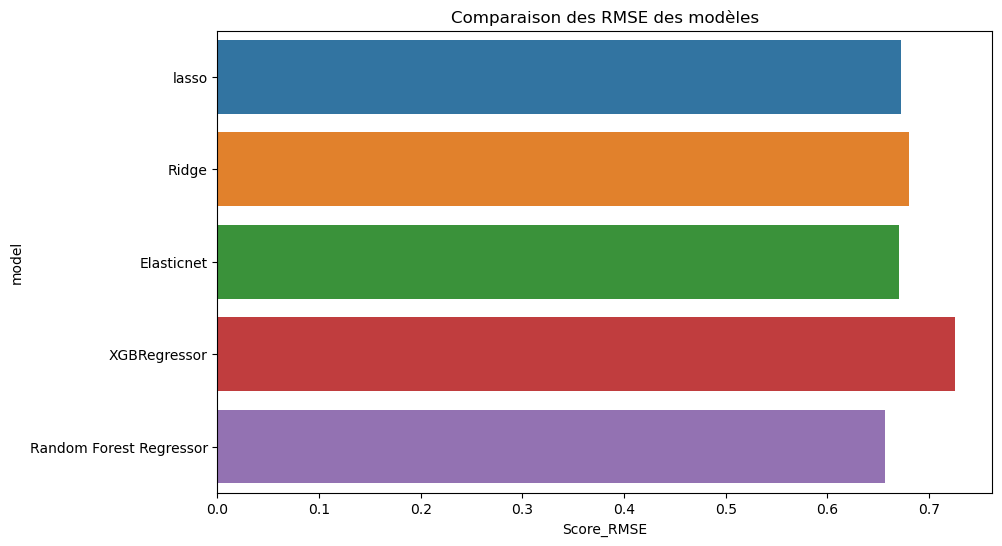

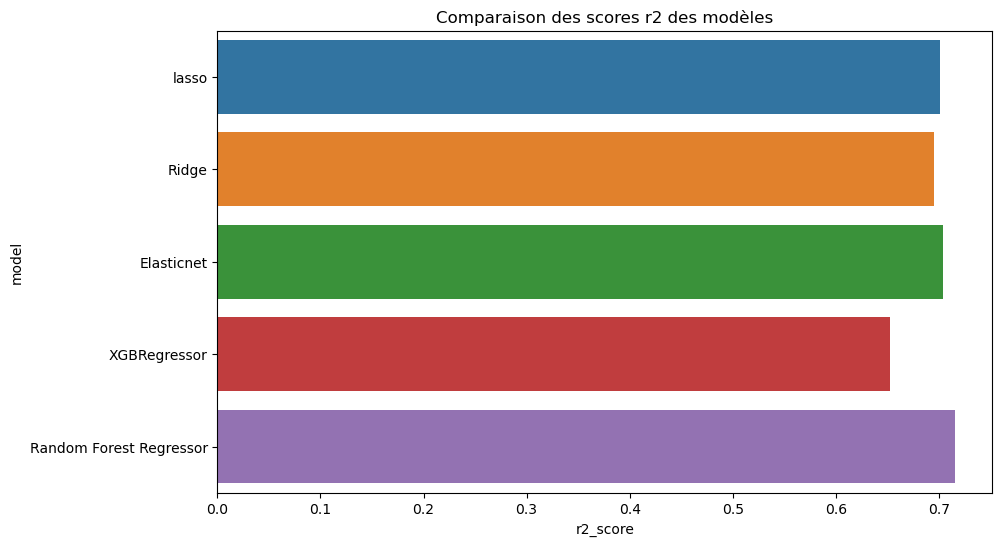

model  Score_RMSE  r2_score  \
0                    lasso    0.672705  0.701439   
1                    Ridge    0.680004  0.694925   
2               Elasticnet    0.669923  0.703903   
3             XGBRegressor    0.725891  0.652362   
4  Random Forest Regressor    0.656081  0.716013   

                                         best_params  
0  {'alpha': 0.003359818286283781, 'selection': '...  
1                      {'alpha': 1.8329807108324339}  
2   {'alpha': 0.001, 'l1_ratio': 0.9, 'tol': 0.0001}  
3  {'gamma': 0.1, 'n_estimators': 1000, 'verbosit...  
4  {'max_features': 'sqrt', 'min_samples_leaf': 1...

In [20]:
find_best_model_using_gridsearchcv(X_train,y_train)

### Feature importance 

#### Feature importance Random Forest Regressor

In [21]:
# load JS visualization code to notebook
shap.initjs()

In [22]:
model_rdr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=1, n_estimators=50)
model_rdr.fit(X_train, y_train)
print(model_rdr.score(X_train, y_train))
print(model_rdr.score(X_test, y_test))

0.9443142831793301
0.7122821096565013


In [23]:
explainer = shap.TreeExplainer(model_rdr)
shap_values = explainer.shap_values(X_train)

##### Force Plot

In [24]:
shap.force_plot(explainer.expected_value, shap_values)

Interpretation: Le Force plot ci-dessus analyse les Shapley values des variables. Les valeurs en rose agissent positivement sur la prédiction et les valeurs en bleu agissent négativement.
La taille de la barre indique l'ampleur de l'effet de la variable sur la prédiction.

##### Summary Plot

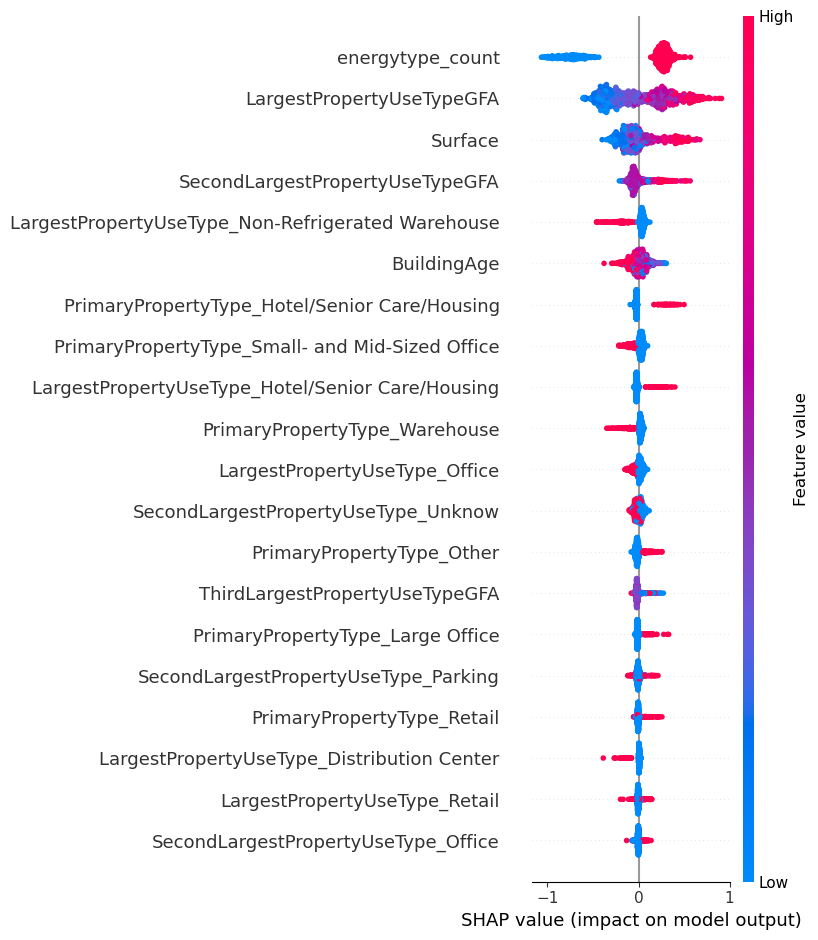

In [25]:
shap.summary_plot(shap_values, features=X_train)

##### Summary Bar Plot

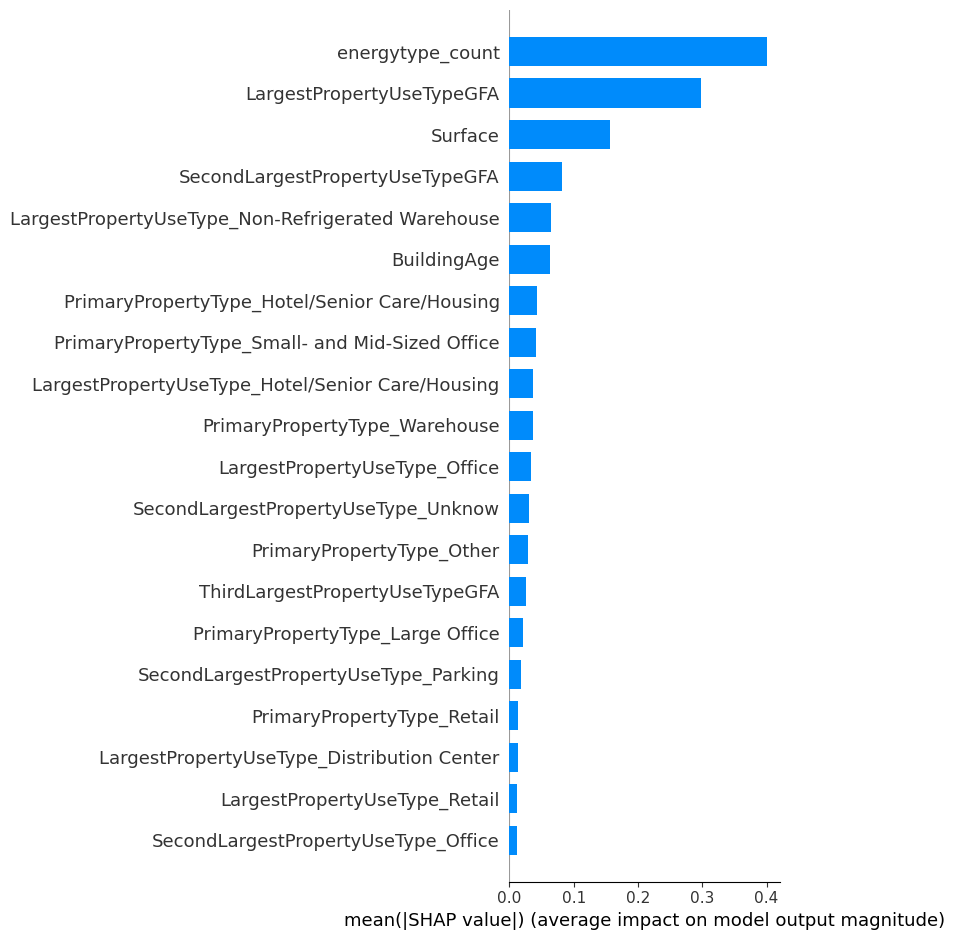

In [26]:
shap.summary_plot(shap_values, features=X_train, plot_type='bar')

##### Dependence plot

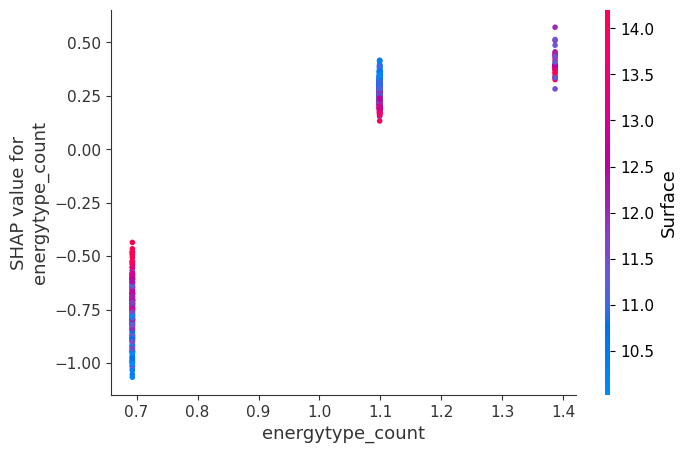

In [27]:
shap.dependence_plot('energytype_count', shap_values, X_train)

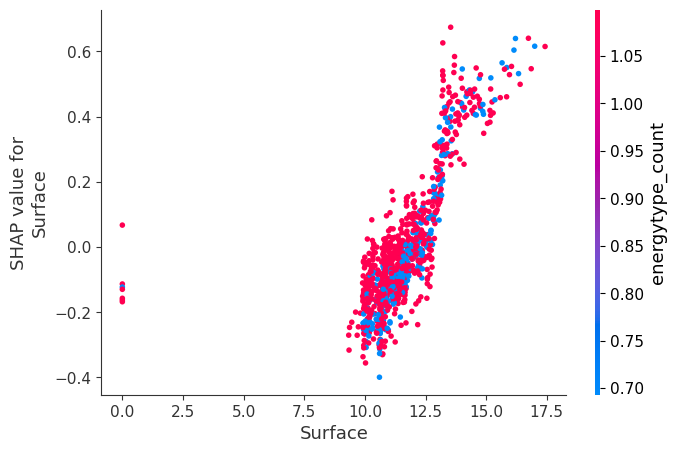

In [28]:
shap.dependence_plot('Surface', shap_values, X_train, feature_names=X_train.columns)

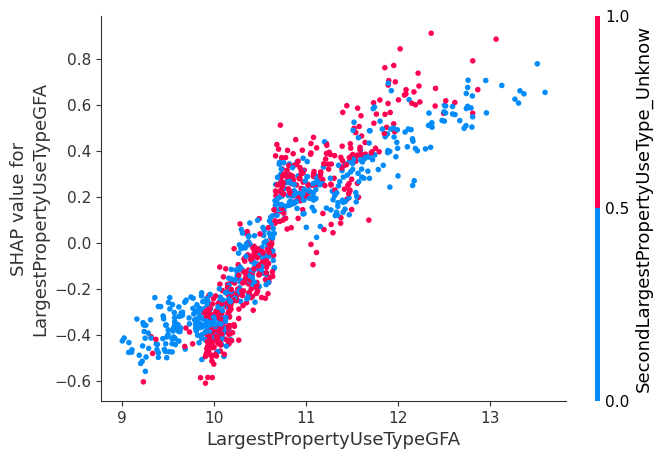

In [29]:
shap.dependence_plot('LargestPropertyUseTypeGFA', shap_values, X_train, feature_names=X_train.columns)

##### Interaction_values, summary_plot

In [30]:
shap_interaction_values = shap.TreeExplainer(model_rdr).shap_interaction_values(X_train)

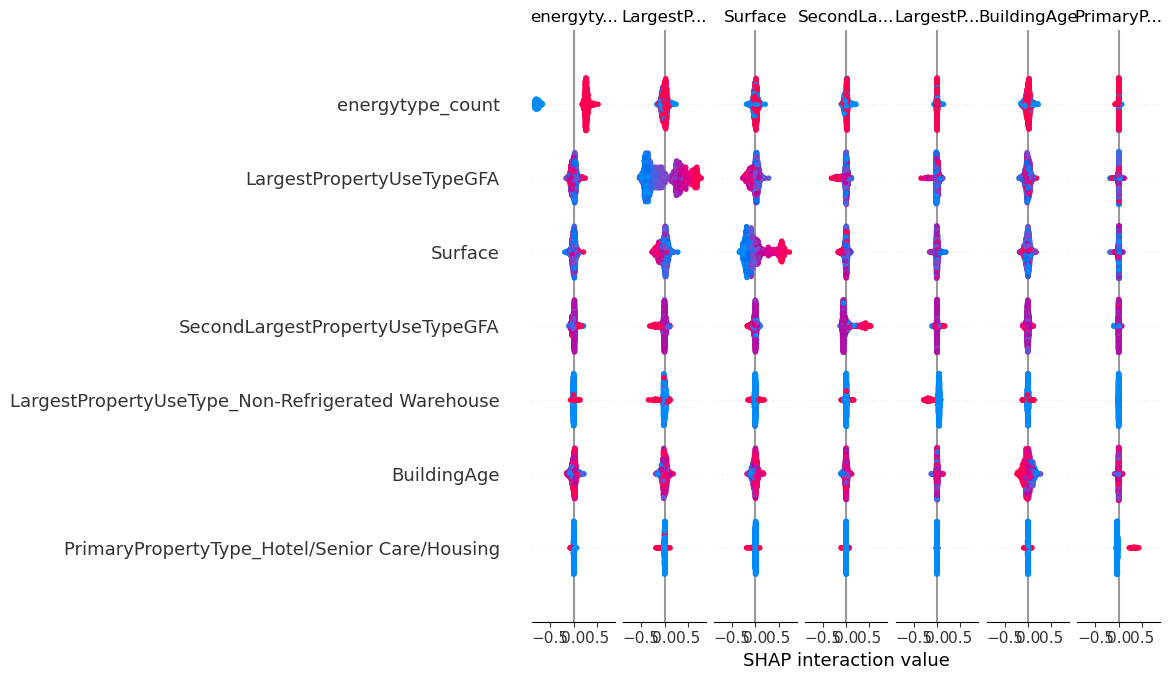

In [31]:
shap.summary_plot(shap_interaction_values, X_train, feature_names=X_train.columns)

## L’influence de l’EnergyStarScore

In [32]:
df_en=table

#### Simulation du modèle Random Forest avec la variable 'ENERGYSTARScore'

In [33]:
features= ['ENERGYSTARScore',
    'energytype_count',
 'Surface',
 'BuildingAge',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions']

In [34]:
df_en=df_en[features]

In [35]:
#Suppression des valeurs manquantes de la colonne 'ENERGYSTARScore'
df_en=df_en.dropna(subset=['ENERGYSTARScore',])


In [36]:
#preprocessing du Dataset
X_train_en,y_train_en, X_test_en, y_test_en = preprocessing(df_en)

In [37]:
#Entrainement du model RandomForestRegressor

In [38]:
model_rdr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=1, n_estimators=50)
model_rdr.fit(X_train_en, y_train_en)
print("Le score de prédiction avec 'ENERGYSTARScore' est de " ,model_rdr.score(X_test_en, y_test_en))

Le score de prédiction avec 'ENERGYSTARScore' est de  0.6695335567157392


#### Feature importance 

In [39]:
explainer = shap.TreeExplainer(model_rdr)
shap_values = explainer.shap_values(X_train_en)

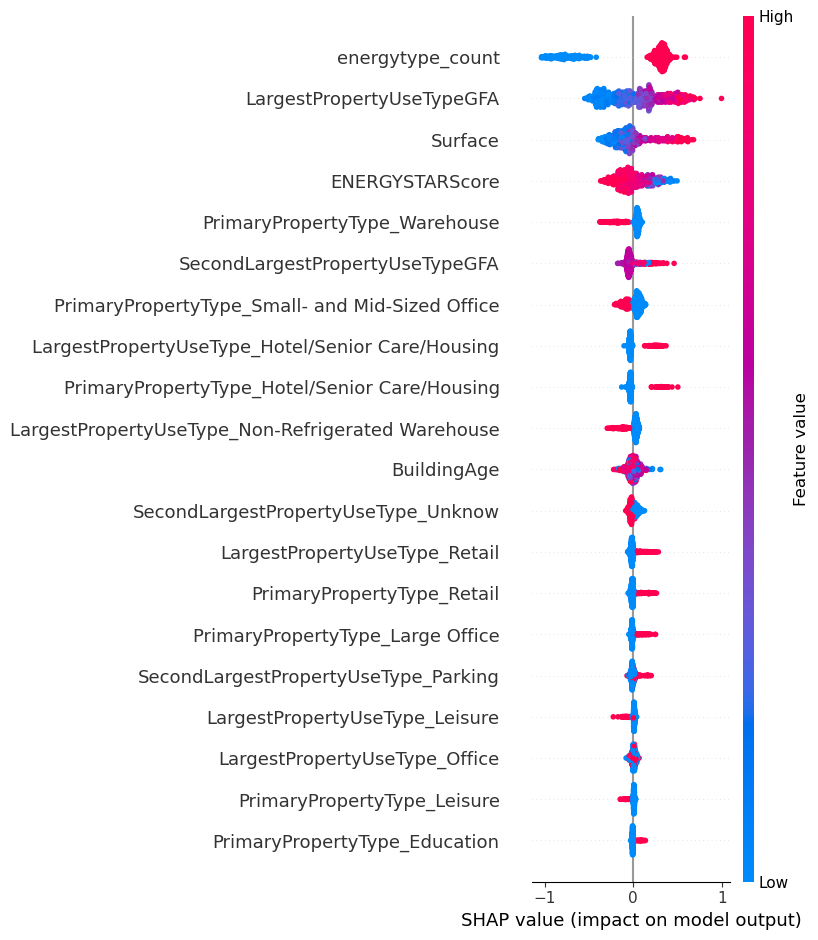

In [40]:
shap.summary_plot(shap_values, features=X_train_en)

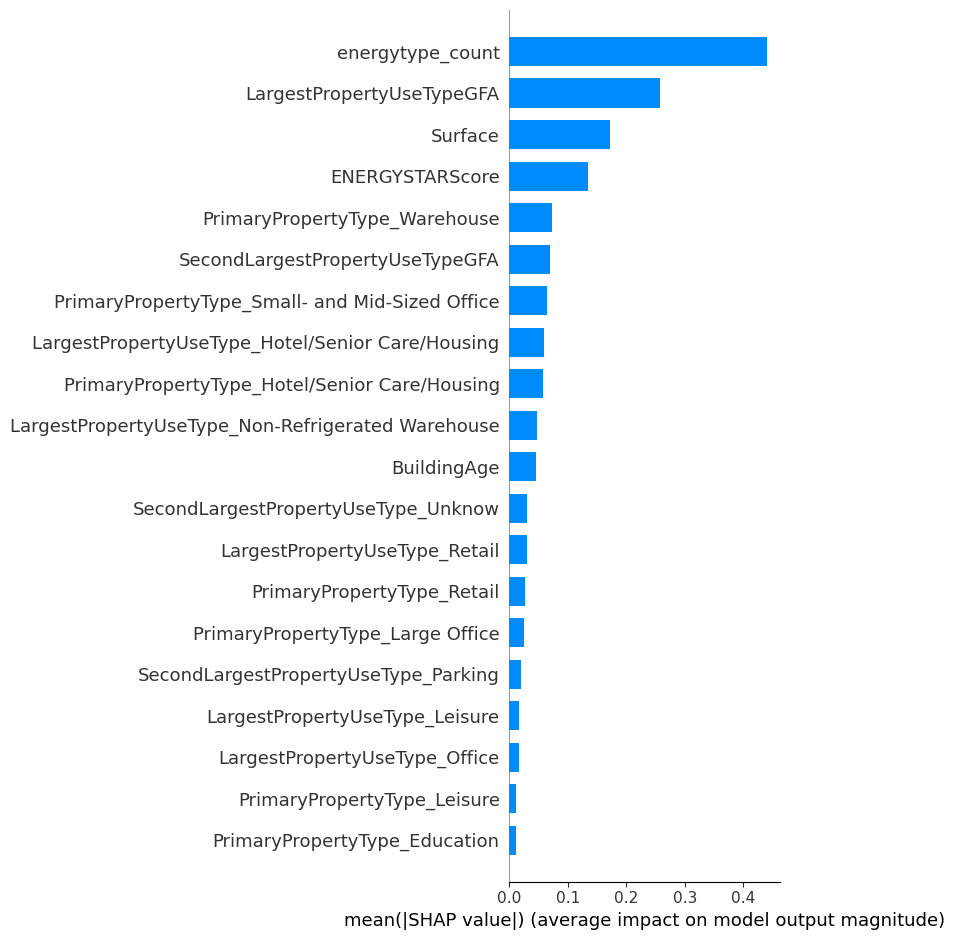

In [41]:
shap.summary_plot(shap_values, X_test_en,plot_type='bar')

In [42]:
shap.force_plot(explainer.expected_value, shap_values, features=X_train_en)

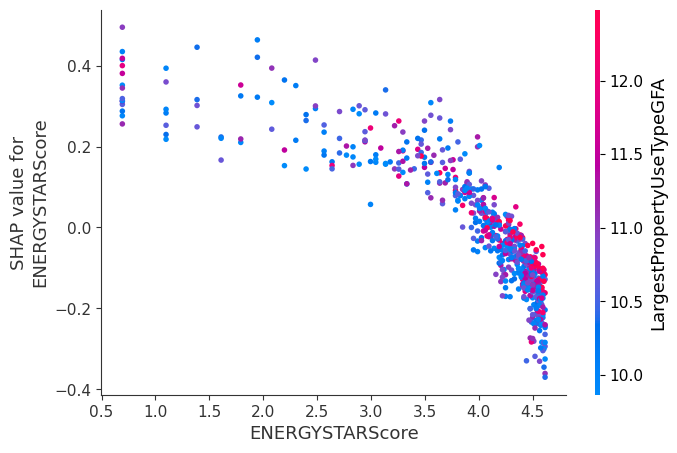

In [43]:
shap.dependence_plot('ENERGYSTARScore', shap_values, X_train_en)

### Entrainement sans la variable 'ENERGYSTARScore'

In [44]:
df_en=df_en.drop('ENERGYSTARScore',axis=1)

In [45]:
X_train_en,y_train_en, X_test_en, y_test_en = preprocessing(df_en)

In [46]:
model_rdr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=1, n_estimators=50)
model_rdr.fit(X_train_en, y_train_en)
print("Le score de prédiction sans 'ENERGYSTARScore' est de ",model_rdr.score(X_test_en, y_test_en))

Le score de prédiction sans 'ENERGYSTARScore' est de  0.5615848168874576
